<a href="https://colab.research.google.com/github/frozenparadox99/SpectralFormer/blob/main/Modelling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/frozenparadox99/SpectralFormer.git

Cloning into 'SpectralFormer'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), 6.35 MiB | 6.08 MiB/s, done.


In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.6 MB/s eta 0:00:00


In [3]:
!pip install "numpy<1.24"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange, repeat

In [5]:
import torch
import argparse
import torch.nn as nn
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
from scipy.io import loadmat
from scipy.io import savemat
from torch import optim
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time
import os

In [6]:
import pandas as pd

In [7]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import lazypredict

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

HSI = "HSI"
dataset = "Indian" # choices=['Indian', 'Pavia', 'Houston'], default='Indian',
flag_test = "train" # choices=['test', 'train'], default='train'
mode = "CAF" # choices=['ViT', 'CAF'], default='ViT'
gpu_id = 0
seed = 0
batch_size = 64 # default 64
test_freq = 5 # default 5
patches = 7 # default 1
band_patches = 3 # default 1
epoches = 300 # default 300
learning_rate = 5e-4 # default 5e-4
gamma = 0.9 # default 0.9
weight_decay = 5e-3 # default 0

In [10]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [11]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [12]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [13]:
class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x, mask = None):
        # x:[b,n,dim]
        b, n, _, h = *x.shape, self.heads

        # get qkv tuple:([b,n,head_num*head_dim],[...],[...])
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        # split q,k,v from [b,n,head_num*head_dim] -> [b,head_num,n,head_dim]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # transpose(k) * q / sqrt(head_dim) -> [b,head_num,n,n]
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max

        # mask value: -inf
        if mask is not None:
            mask = nn.F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask

        # softmax normalization -> attention matrix
        attn = dots.softmax(dim=-1)
        # value * attention matrix -> output
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        # cat all output -> [b, n, head_num*head_dim]
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

In [14]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_head, dropout, num_channel, mode):
        super().__init__()

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_head, dropout = dropout)))
            ]))

        self.mode = mode
        self.skipcat = nn.ModuleList([])
        for _ in range(depth-2):
            self.skipcat.append(nn.Conv2d(num_channel+1, num_channel+1, [1, 2], 1, 0))

    def forward(self, x, mask = None):
        if self.mode == 'ViT':
            for attn, ff in self.layers:
                x = attn(x, mask = mask)
                x = ff(x)
        elif self.mode == 'CAF':
            last_output = []
            nl = 0
            for attn, ff in self.layers:
                last_output.append(x)
                if nl > 1:
                    x = self.skipcat[nl-2](torch.cat([x.unsqueeze(3), last_output[nl-2].unsqueeze(3)], dim=3)).squeeze(3)
                x = attn(x, mask = mask)
                x = ff(x)
                nl += 1

        return x

In [15]:
class ViT(nn.Module):
    def __init__(self, image_size, near_band, num_patches, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=1, dim_head = 16, dropout=0., emb_dropout=0., mode='ViT'):
        super().__init__()

        patch_dim = image_size ** 2 * near_band

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout, num_patches, mode)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    def forward(self, x, mask = None):

        # patchs[batch, patch_num, patch_size*patch_size*c]  [batch,200,145*145]
        # x = rearrange(x, 'b c h w -> b c (h w)')

        ## embedding every patch vector to embedding size: [batch, patch_num, embedding_size]
        x = self.patch_to_embedding(x) #[b,n,dim]
        b, n, _ = x.shape

        # add position embedding
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b) #[b,1,dim]
        x = torch.cat((cls_tokens, x), dim = 1) #[b,n+1,dim]
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        # transformer: x[b,n + 1,dim] -> x[b,n + 1,dim]
        x = self.transformer(x, mask)

        # classification: using cls_token output
        x = self.to_latent(x[:,0])

        # MLP classification layer
        return self.mlp_head(x)

In [16]:
def chooose_train_and_test_point(train_data, test_data, true_data, num_classes):
    # Train data shape => 145,145 which is TR
    number_train = []
    pos_train = {}
    number_test = []
    pos_test = {}
    number_true = []
    pos_true = {}
    #-------------------------for train data------------------------------------
    # Loop goes from 0 to 16
    for i in range(num_classes):
        each_class = []
        each_class = np.argwhere(train_data==(i+1))
        number_train.append(each_class.shape[0])
        pos_train[i] = each_class

    total_pos_train = pos_train[0]
    for i in range(1, num_classes):
        total_pos_train = np.r_[total_pos_train, pos_train[i]] #(695,2)
    total_pos_train = total_pos_train.astype(int)
    #--------------------------for test data------------------------------------
    for i in range(num_classes):
        each_class = []
        each_class = np.argwhere(test_data==(i+1))
        number_test.append(each_class.shape[0])
        pos_test[i] = each_class

    total_pos_test = pos_test[0]
    for i in range(1, num_classes):
        total_pos_test = np.r_[total_pos_test, pos_test[i]] #(9671,2)
    total_pos_test = total_pos_test.astype(int)
    #--------------------------for true data------------------------------------
    for i in range(num_classes+1):
        each_class = []
        each_class = np.argwhere(true_data==i)
        number_true.append(each_class.shape[0])
        pos_true[i] = each_class

    total_pos_true = pos_true[0]
    for i in range(1, num_classes+1):
        total_pos_true = np.r_[total_pos_true, pos_true[i]]
    total_pos_true = total_pos_true.astype(int)

    return total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true

In [17]:
def mirror_hsi(height,width,band,input_normalize,patch=5):
    padding=patch//2
    mirror_hsi=np.zeros((height+2*padding,width+2*padding,band),dtype=float)
    #中心区域
    mirror_hsi[padding:(padding+height),padding:(padding+width),:]=input_normalize
    #左边镜像
    for i in range(padding):
        mirror_hsi[padding:(height+padding),i,:]=input_normalize[:,padding-i-1,:]
    #右边镜像
    for i in range(padding):
        mirror_hsi[padding:(height+padding),width+padding+i,:]=input_normalize[:,width-1-i,:]
    #上边镜像
    for i in range(padding):
        mirror_hsi[i,:,:]=mirror_hsi[padding*2-i-1,:,:]
    #下边镜像
    for i in range(padding):
        mirror_hsi[height+padding+i,:,:]=mirror_hsi[height+padding-1-i,:,:]

    print("**************************************************")
    print("patch is : {}".format(patch))
    print("mirror_image shape : [{0},{1},{2}]".format(mirror_hsi.shape[0],mirror_hsi.shape[1],mirror_hsi.shape[2]))
    print("**************************************************")
    return mirror_hsi

In [18]:
def gain_neighborhood_pixel(mirror_image, point, i, patch=5):
    x = point[i,0]
    y = point[i,1]
    temp_image = mirror_image[x:(x+patch),y:(y+patch),:]
    return temp_image

In [19]:
def gain_neighborhood_band(x_train, band, band_patch, patch=5):
    nn = band_patch // 2
    pp = (patch*patch) // 2
    x_train_reshape = x_train.reshape(x_train.shape[0], patch*patch, band)
    x_train_band = np.zeros((x_train.shape[0], patch*patch*band_patch, band),dtype=float)
    # 中心区域
    x_train_band[:,nn*patch*patch:(nn+1)*patch*patch,:] = x_train_reshape
    #左边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,:i+1] = x_train_reshape[:,:,band-i-1:]
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,i+1:] = x_train_reshape[:,:,:band-i-1]
        else:
            x_train_band[:,i:(i+1),:(nn-i)] = x_train_reshape[:,0:1,(band-nn+i):]
            x_train_band[:,i:(i+1),(nn-i):] = x_train_reshape[:,0:1,:(band-nn+i)]
    #右边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,:band-i-1] = x_train_reshape[:,:,i+1:]
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,band-i-1:] = x_train_reshape[:,:,:i+1]
        else:
            x_train_band[:,(nn+1+i):(nn+2+i),(band-i-1):] = x_train_reshape[:,0:1,:(i+1)]
            x_train_band[:,(nn+1+i):(nn+2+i),:(band-i-1)] = x_train_reshape[:,0:1,(i+1):]
    return x_train_band

In [20]:
def train_and_test_data(mirror_image, band, train_point, test_point, true_point, patch=5, band_patch=3):
    x_train = np.zeros((train_point.shape[0], patch, patch, band), dtype=float)
    x_test = np.zeros((test_point.shape[0], patch, patch, band), dtype=float)
    x_true = np.zeros((true_point.shape[0], patch, patch, band), dtype=float)
    for i in range(train_point.shape[0]):
        x_train[i,:,:,:] = gain_neighborhood_pixel(mirror_image, train_point, i, patch)
    for j in range(test_point.shape[0]):
        x_test[j,:,:,:] = gain_neighborhood_pixel(mirror_image, test_point, j, patch)
    for k in range(true_point.shape[0]):
        x_true[k,:,:,:] = gain_neighborhood_pixel(mirror_image, true_point, k, patch)
    print("x_train shape = {}, type = {}".format(x_train.shape,x_train.dtype))
    print("x_test  shape = {}, type = {}".format(x_test.shape,x_test.dtype))
    print("x_true  shape = {}, type = {}".format(x_true.shape,x_test.dtype))
    print("**************************************************")

    x_train_band = gain_neighborhood_band(x_train, band, band_patch, patch)
    x_test_band = gain_neighborhood_band(x_test, band, band_patch, patch)
    x_true_band = gain_neighborhood_band(x_true, band, band_patch, patch)
    print("x_train_band shape = {}, type = {}".format(x_train_band.shape,x_train_band.dtype))
    print("x_test_band  shape = {}, type = {}".format(x_test_band.shape,x_test_band.dtype))
    print("x_true_band  shape = {}, type = {}".format(x_true_band.shape,x_true_band.dtype))
    print("**************************************************")
    return x_train_band, x_test_band, x_true_band

In [21]:
def train_and_test_label(number_train, number_test, number_true, num_classes):
    y_train = []
    y_test = []
    y_true = []
    for i in range(num_classes):
        for j in range(number_train[i]):
            y_train.append(i)
        for k in range(number_test[i]):
            y_test.append(i)
    for i in range(num_classes+1):
        for j in range(number_true[i]):
            y_true.append(i)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_true = np.array(y_true)
    print("y_train: shape = {} ,type = {}".format(y_train.shape,y_train.dtype))
    print("y_test: shape = {} ,type = {}".format(y_test.shape,y_test.dtype))
    print("y_true: shape = {} ,type = {}".format(y_true.shape,y_true.dtype))
    print("**************************************************")
    return y_train, y_test, y_true

In [22]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [23]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res, target, pred.squeeze()

In [24]:
def train_epoch(model, train_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(train_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

        optimizer.zero_grad()
        batch_pred = model(batch_data)
        loss = criterion(batch_pred, batch_target)
        loss.backward()
        optimizer.step()

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())
    return top1.avg, objs.avg, tar, pre

In [25]:
def valid_epoch(model, valid_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(valid_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

        batch_pred = model(batch_data)

        loss = criterion(batch_pred, batch_target)

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())

    return tar, pre

def test_epoch(model, test_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(test_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

        batch_pred = model(batch_data)

        _, pred = batch_pred.topk(1, 1, True, True)
        pp = pred.squeeze()
        pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [26]:
def output_metric(tar, pre):
    matrix = confusion_matrix(tar, pre)
    OA, AA_mean, Kappa, AA = cal_results(matrix)
    return OA, AA_mean, Kappa, AA

In [27]:
def cal_results(matrix):
    shape = np.shape(matrix)
    number = 0
    sum = 0
    AA = np.zeros([shape[0]], dtype=np.float)
    for i in range(shape[0]):
        number += matrix[i, i]
        AA[i] = matrix[i, i] / np.sum(matrix[i, :])
        sum += np.sum(matrix[i, :]) * np.sum(matrix[:, i])
    OA = number / np.sum(matrix)
    AA_mean = np.mean(AA)
    pe = sum / (np.sum(matrix) ** 2)
    Kappa = (OA - pe) / (1 - pe)
    return OA, AA_mean, Kappa, AA

# This is our experimental section

In [ ]:
data = loadmat('/content/SpectralFormer/IndianPine.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Feb  5 15:03:09 2021',
 '__version__': '1.0',
 '__globals__': [],
 'TE': array([[2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'TR': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'input': array([[[3172, 4142, 4506, ..., 1057, 1020, 1020],
         [3348, 4266, 4502, ..., 1064, 1029, 1020],
         [3687, 4266, 4421, ..., 1061, 1030, 1016],
         ...,
         [3341, 3890, 4320, ..., 1042, 1021, 1015],
         [3170, 4130, 4320, ..., 1054, 1024, 1020],
         [3172, 3890, 4316, ..., 1043, 1034, 1016]],
 
        [[3344, 4388, 4334, ..., 1047, 1030, 1006],
        

In [ ]:
color_mat = loadmat('/content/SpectralFormer/AVIRIS_colormap.mat')
color_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Dec 13 13:13:31 2011',
 '__version__': '1.0',
 '__globals__': [],
 'mycolormap': array([[1.  , 1.  , 1.  ],
        [1.  , 1.  , 0.5 ],
        [0.  , 0.  , 1.  ],
        [1.  , 0.  , 0.  ],
        [0.  , 1.  , 0.25],
        [1.  , 0.  , 1.  ],
        [0.5 , 0.  , 1.  ],
        [0.  , 0.5 , 1.  ],
        [0.  , 1.  , 0.  ],
        [0.5 , 0.5 , 0.25],
        [0.5 , 0.  , 0.5 ],
        [0.  , 0.5 , 1.  ],
        [0.  , 0.25, 0.5 ],
        [0.  , 0.5 , 0.25],
        [0.5 , 0.25, 0.  ],
        [0.  , 1.  , 0.5 ],
        [1.  , 1.  , 0.  ]])}

In [ ]:
sample_my_color_map = color_mat['mycolormap']
sample_my_color_map

array([[1.  , 1.  , 1.  ],
       [1.  , 1.  , 0.5 ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.25],
       [1.  , 0.  , 1.  ],
       [0.5 , 0.  , 1.  ],
       [0.  , 0.5 , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.5 , 0.5 , 0.25],
       [0.5 , 0.  , 0.5 ],
       [0.  , 0.5 , 1.  ],
       [0.  , 0.25, 0.5 ],
       [0.  , 0.5 , 0.25],
       [0.5 , 0.25, 0.  ],
       [0.  , 1.  , 0.5 ],
       [1.  , 1.  , 0.  ]])

In [ ]:
sample_my_color_map.shape

(17, 3)

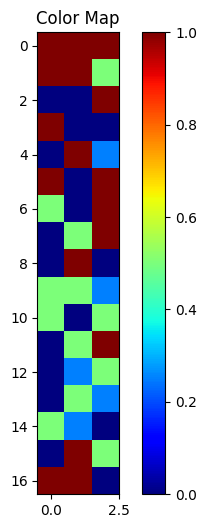

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(sample_my_color_map, cmap='jet')
plt.colorbar()
plt.title('Color Map')
plt.show()

In [ ]:
TR = data['TR']
TE = data['TE']
input = data['input']

In [ ]:
TR

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
TR.shape

(145, 145)

In [ ]:
TE

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
TE.shape

(145, 145)

In [ ]:
input

array([[[3172, 4142, 4506, ..., 1057, 1020, 1020],
        [3348, 4266, 4502, ..., 1064, 1029, 1020],
        [3687, 4266, 4421, ..., 1061, 1030, 1016],
        ...,
        [3341, 3890, 4320, ..., 1042, 1021, 1015],
        [3170, 4130, 4320, ..., 1054, 1024, 1020],
        [3172, 3890, 4316, ..., 1043, 1034, 1016]],

       [[3344, 4388, 4334, ..., 1047, 1030, 1006],
        [3515, 4264, 4592, ..., 1055, 1039, 1015],
        [3518, 4268, 4423, ..., 1047, 1026, 1015],
        ...,
        [3859, 4512, 4605, ..., 1056, 1035, 1015],
        [3686, 4264, 4690, ..., 1051, 1012, 1020],
        [3512, 4268, 4597, ..., 1047, 1019, 1016]],

       [[3512, 4146, 4416, ..., 1055, 1029, 1025],
        [3344, 4389, 4416, ..., 1051, 1021, 1011],
        [3512, 4273, 4420, ..., 1068, 1033, 1010],
        ...,
        [3341, 4266, 4509, ..., 1051, 1025, 1010],
        [3344, 4262, 4496, ..., 1047, 1029, 1020],
        [3510, 4142, 4230, ..., 1042, 1025, 1011]],

       ...,

       [[3324, 3728, 400

In [ ]:
input.shape

(145, 145, 200)

In [ ]:
type(input)

numpy.ndarray

In [ ]:
label = TR + TE
label

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
num_classes = np.max(TR)

In [ ]:
num_classes

16

In [ ]:
color_mat_list = list(color_mat)
color_mat_list

['__header__', '__version__', '__globals__', 'mycolormap']

In [ ]:
color_matrix = color_mat[color_mat_list[3]] #(17,3)
color_matrix

array([[1.  , 1.  , 1.  ],
       [1.  , 1.  , 0.5 ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.25],
       [1.  , 0.  , 1.  ],
       [0.5 , 0.  , 1.  ],
       [0.  , 0.5 , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.5 , 0.5 , 0.25],
       [0.5 , 0.  , 0.5 ],
       [0.  , 0.5 , 1.  ],
       [0.  , 0.25, 0.5 ],
       [0.  , 0.5 , 0.25],
       [0.5 , 0.25, 0.  ],
       [0.  , 1.  , 0.5 ],
       [1.  , 1.  , 0.  ]])

In [ ]:
height, width, band = input.shape
print("height={0},width={1},band={2}".format(height, width, band))

height=145,width=145,band=200


In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 19.8 MB/s eta 0:00:00


In [ ]:
import spectral

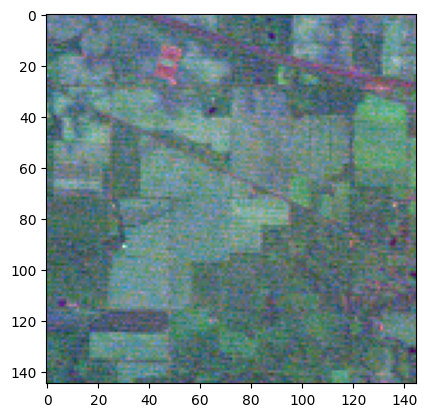

In [ ]:
spectral_image = spectral.imshow(input)

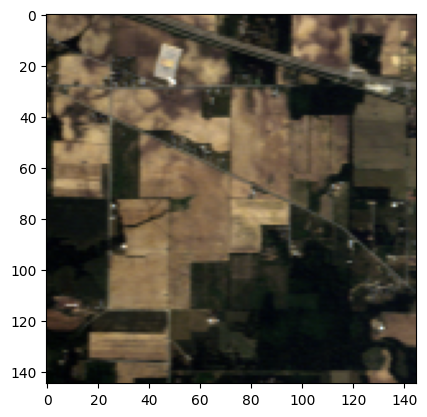

In [ ]:
spectral_image = spectral.imshow(input, (29, 19, 9))

In [ ]:
type(spectral_image)

spectral.graphics.spypylab.ImageView

In [ ]:
print(spectral_image)

ImageView object:
  Display bands       :  [0, 100.0, 199]
  Interpolation       :  <default>
  RGB data limits     :
    R: [2632.0, 4536.0]
    G: [1169.0, 2511.0]
    B: [981.0, 1037.0]



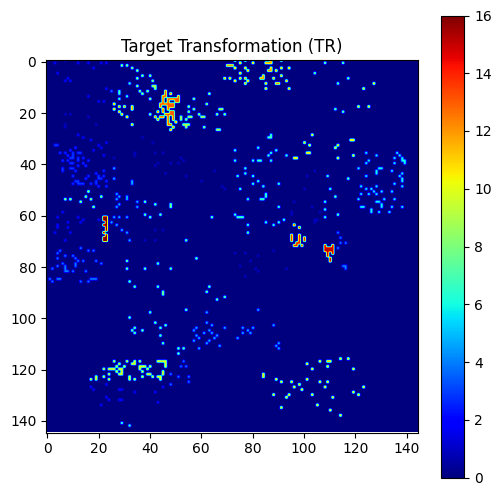

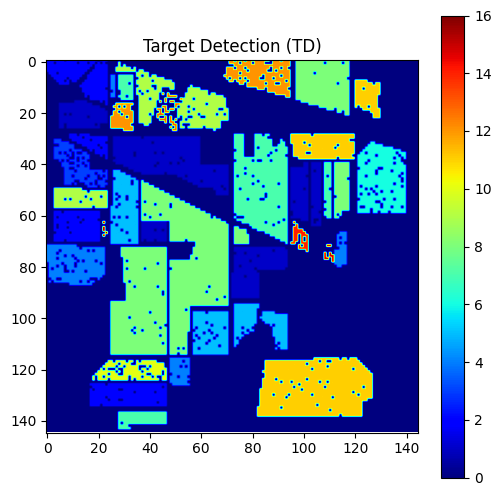

In [ ]:
# Plot TR
plt.figure(figsize=(6, 6))
plt.imshow(TR, cmap='jet')
plt.colorbar()
plt.title('Target Transformation (TR)')
plt.show()

# Plot TD
plt.figure(figsize=(6, 6))
plt.imshow(TE, cmap='jet')
plt.colorbar()
plt.title('Target Detection (TD)')
plt.show()

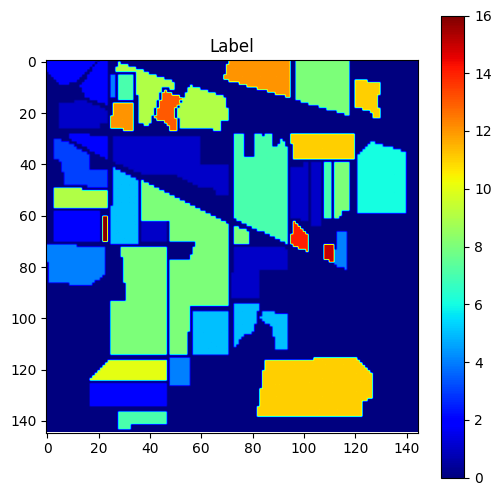

In [ ]:
# Plot Label
plt.figure(figsize=(6, 6))
plt.imshow(label, cmap='jet')
plt.colorbar()
plt.title('Label')
plt.show()

In [ ]:
TR.shape

(145, 145)

In [ ]:
number_train_custom = []
pos_train_custom = {}
for i in range(num_classes):
    print('Starting epoch: ', i)
    each_class = []
    each_class = np.argwhere(TR==(i+1))

    print(each_class)
    print(each_class.shape)
    print("---------------------------")
    number_train_custom.append(each_class.shape[0])
    pos_train_custom[i] = each_class


Starting epoch:  0
[[ 21   7]
 [ 21   9]
 [ 22  16]
 [ 25   7]
 [ 25  19]
 [ 26   7]
 [ 30  37]
 [ 32  41]
 [ 36  34]
 [ 36  42]
 [ 36  45]
 [ 37  34]
 [ 38  26]
 [ 38  52]
 [ 39  53]
 [ 40  43]
 [ 40  48]
 [ 40  51]
 [ 41  42]
 [ 43  65]
 [ 43 104]
 [ 44  46]
 [ 45  54]
 [ 45 101]
 [ 47  60]
 [ 49  68]
 [ 50  69]
 [ 50 100]
 [ 55  96]
 [ 57 103]
 [ 59  95]
 [ 59 106]
 [ 60  95]
 [ 62 104]
 [ 62 105]
 [ 63 104]
 [ 66  42]
 [ 66  45]
 [ 70  38]
 [ 70  42]
 [ 74  88]
 [ 75  73]
 [ 75  77]
 [ 76  82]
 [ 78  79]
 [ 80  75]
 [ 81  81]
 [ 81  93]
 [ 82  82]
 [ 84  77]]
(50, 2)
---------------------------
Starting epoch:  1
[[  0   7]
 [  1   3]
 [  1  12]
 [  1  16]
 [  1  21]
 [  1  23]
 [  3  18]
 [  5   4]
 [  7   8]
 [  8   7]
 [  8   9]
 [ 11  23]
 [ 14  16]
 [ 16  20]
 [ 16  22]
 [ 29  12]
 [ 30  14]
 [ 31  17]
 [ 32  23]
 [ 33  20]
 [ 34  21]
 [ 35  18]
 [ 37  22]
 [ 59   6]
 [ 61   4]
 [ 61  12]
 [ 62  14]
 [ 62  20]
 [ 63   8]
 [ 63  13]
 [ 64   4]
 [ 65   4]
 [ 65   8]
 [ 67   3]
 

In [ ]:
number_train_custom

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 15, 15, 15]

In [ ]:
pos_train_custom

{0: array([[ 21,   7],
        [ 21,   9],
        [ 22,  16],
        [ 25,   7],
        [ 25,  19],
        [ 26,   7],
        [ 30,  37],
        [ 32,  41],
        [ 36,  34],
        [ 36,  42],
        [ 36,  45],
        [ 37,  34],
        [ 38,  26],
        [ 38,  52],
        [ 39,  53],
        [ 40,  43],
        [ 40,  48],
        [ 40,  51],
        [ 41,  42],
        [ 43,  65],
        [ 43, 104],
        [ 44,  46],
        [ 45,  54],
        [ 45, 101],
        [ 47,  60],
        [ 49,  68],
        [ 50,  69],
        [ 50, 100],
        [ 55,  96],
        [ 57, 103],
        [ 59,  95],
        [ 59, 106],
        [ 60,  95],
        [ 62, 104],
        [ 62, 105],
        [ 63, 104],
        [ 66,  42],
        [ 66,  45],
        [ 70,  38],
        [ 70,  42],
        [ 74,  88],
        [ 75,  73],
        [ 75,  77],
        [ 76,  82],
        [ 78,  79],
        [ 80,  75],
        [ 81,  81],
        [ 81,  93],
        [ 82,  82],
        [ 84,  77

In [ ]:
total_pos_train_custom = pos_train_custom[0]

for i in range(1, num_classes):
    total_pos_train_custom = np.r_[total_pos_train_custom, pos_train_custom[i]] #(695,2) # This is normal concatenation
    print(total_pos_train_custom.shape)
total_pos_train_custom = total_pos_train_custom.astype(int)

(100, 2)
(150, 2)
(200, 2)
(250, 2)
(300, 2)
(350, 2)
(400, 2)
(450, 2)
(500, 2)
(550, 2)
(600, 2)
(650, 2)
(665, 2)
(680, 2)
(695, 2)


In [ ]:
total_pos_train_custom.shape

(695, 2)

In [ ]:
pos_train_custom[0].shape

(50, 2)

# Experimental section ends

In [28]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False
# prepare data
if dataset == 'Indian':
    data = loadmat('/content/SpectralFormer/IndianPine.mat')
elif dataset == 'Pavia':
    data = loadmat('/content/Pavia.mat')
elif dataset == 'Houston':
    data = loadmat('/content/Houston.mat')
else:
    raise ValueError("Unkknow dataset")
color_mat = loadmat('/content/SpectralFormer/AVIRIS_colormap.mat')
TR = data['TR']
TE = data['TE']
input = data['input'] #(145,145,200)
label = TR + TE
num_classes = np.max(TR)

color_mat_list = list(color_mat)
color_matrix = color_mat[color_mat_list[3]] #(17,3)
# normalize data by band norm
input_normalize = np.zeros(input.shape)
for i in range(input.shape[2]):
    input_max = np.max(input[:,:,i])
    input_min = np.min(input[:,:,i])
    input_normalize[:,:,i] = (input[:,:,i]-input_min)/(input_max-input_min)
# data size
height, width, band = input.shape
print("height={0},width={1},band={2}".format(height, width, band))

height=145,width=145,band=200


In [29]:
# Shapes: TR => 145,145, TE => 145,145, Label => 145,145, num_classes=> 16
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = chooose_train_and_test_point(TR, TE, label, num_classes)
mirror_image = mirror_hsi(height, width, band, input_normalize, patch=patches)
x_train_band, x_test_band, x_true_band = train_and_test_data(mirror_image, band, total_pos_train, total_pos_test, total_pos_true, patch=patches, band_patch=band_patches)
y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch is : 7
mirror_image shape : [151,151,200]
**************************************************
x_train shape = (695, 7, 7, 200), type = float64
x_test  shape = (9671, 7, 7, 200), type = float64
x_true  shape = (21025, 7, 7, 200), type = float64
**************************************************
x_train_band shape = (695, 147, 200), type = float64
x_test_band  shape = (9671, 147, 200), type = float64
x_true_band  shape = (21025, 147, 200), type = float64
**************************************************
y_train: shape = (695,) ,type = int64
y_test: shape = (9671,) ,type = int64
y_true: shape = (21025,) ,type = int64
**************************************************


In [ ]:
x_train=torch.from_numpy(x_train_band.transpose(0,2,1)).type(torch.FloatTensor) #[695, 200, 7, 7]
y_train=torch.from_numpy(y_train).type(torch.LongTensor) #[695]
Label_train=Data.TensorDataset(x_train,y_train)
x_test=torch.from_numpy(x_test_band.transpose(0,2,1)).type(torch.FloatTensor) # [9671, 200, 7, 7]
y_test=torch.from_numpy(y_test).type(torch.LongTensor) # [9671]
Label_test=Data.TensorDataset(x_test,y_test)
x_true=torch.from_numpy(x_true_band.transpose(0,2,1)).type(torch.FloatTensor)
y_true=torch.from_numpy(y_true).type(torch.LongTensor)
Label_true=Data.TensorDataset(x_true,y_true)

label_train_loader=Data.DataLoader(Label_train,batch_size=batch_size,shuffle=True)
label_test_loader=Data.DataLoader(Label_test,batch_size=batch_size,shuffle=True)
label_true_loader=Data.DataLoader(Label_true,batch_size=100,shuffle=False)

# Custom model begins

In [30]:
x_train=torch.from_numpy(x_train_band.transpose(0,2,1)).type(torch.FloatTensor) #[695, 200, 7, 7]
y_train=torch.from_numpy(y_train).type(torch.LongTensor) #[695]


In [51]:
x_train.shape

torch.Size([695, 200, 147])

In [32]:
y_train.shape

torch.Size([695])

## Traditional ML models

In [49]:
# Reshape the tensor to a 1D tensor
custom_x_train = x_train.reshape([695, 200*147])

# Convert the tensor to a NumPy ndarray
custom_x_train_np = custom_x_train.numpy()

In [50]:
custom_x_train_np.shape

(695, 29400)

In [52]:
custom_y_train_np = y_train.numpy()

In [54]:
custom_y_train_np.shape

(695,)

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train_custom_1, X_test_custom_1, y_train_custom_1, y_test_custom_1 = train_test_split(custom_x_train_np, custom_y_train_np ,test_size=.3,random_state =123)

In [58]:
X_train_custom_1.shape

(486, 29400)

In [59]:
y_train_custom_1.shape

(486,)

In [60]:
from lazypredict.Supervised import LazyClassifier

In [62]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models_custom,predictions_custom = clf.fit(X_train_custom_1, X_test_custom_1, y_train_custom_1, y_test_custom_1)
models_custom

100%|██████████| 29/29 [1:36:31<00:00, 199.69s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.78,0.80,None,0.78,2.29
LinearDiscriminantAnalysis,0.78,0.80,None,0.79,5.65
LogisticRegression,0.75,0.77,None,0.75,22.96
RandomForestClassifier,0.74,0.76,None,0.74,4.93
LGBMClassifier,0.73,0.74,None,0.74,1359.12
RidgeClassifier,0.71,0.71,None,0.71,1.29
RidgeClassifierCV,0.71,0.71,None,0.71,1.75
BaggingClassifier,0.69,0.71,None,0.70,66.05
XGBClassifier,0.70,0.70,None,0.71,657.16


## End of traditional ML models

In [ ]:
import torch.optim as optim

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super(LSTMClassifier, self).__init__()

        self.rnn = nn.LSTM(input_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x = [batch size, seq len, num features]

        output, (hidden, cell) = self.rnn(x)
        hidden = self.dropout(hidden[-1,:,:]) # we only want the final hidden state

        return self.fc(hidden)

# Hyperparameters
input_dim = 147
hidden_dim = 256
output_dim = 16  # The number of classes
n_layers = 1
dropout = 0.2
epochs = 10

model = LSTMClassifier(input_dim, hidden_dim, output_dim, n_layers, dropout)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())



# Training loop
for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    predictions = model(x_train)
    # predictions has shape [batch_size, n_classes], y_train has shape [batch_size]
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    print(f'Epoch: {epoch+1:02}, Loss: {loss.item()}')

Epoch: 01, Loss: 2.781511068344116
Epoch: 02, Loss: 2.7447338104248047
Epoch: 03, Loss: 2.714019775390625
Epoch: 04, Loss: 2.6884806156158447
Epoch: 05, Loss: 2.6703364849090576
Epoch: 06, Loss: 2.6560542583465576
Epoch: 07, Loss: 2.6437556743621826
Epoch: 08, Loss: 2.6046993732452393
Epoch: 09, Loss: 2.556224822998047
Epoch: 10, Loss: 2.4902431964874268


In [ ]:
def calculate_accuracy(y_true, y_pred):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y_true.view_as(top_pred)).sum()
    acc = correct.float() / y_true.shape[0]
    return acc

In [ ]:
model2 = LSTMClassifier(input_dim, hidden_dim, output_dim, n_layers, dropout)

In [ ]:
for epoch in range(epochs):
    model2.train()

    optimizer.zero_grad()
    predictions = model2(x_train)
    loss = criterion(predictions, y_train)

    acc = calculate_accuracy(y_train, predictions)

    loss.backward()
    optimizer.step()

    print(f'Epoch: {epoch+1:02}, Loss: {loss.item()}, Accuracy: {acc.item()}')

Epoch: 01, Loss: 2.7795450687408447, Accuracy: 0.05899280682206154
Epoch: 02, Loss: 2.7795233726501465, Accuracy: 0.04172661900520325
Epoch: 03, Loss: 2.7812957763671875, Accuracy: 0.046043165028095245
Epoch: 04, Loss: 2.778860092163086, Accuracy: 0.050359711050987244
Epoch: 05, Loss: 2.777710199356079, Accuracy: 0.05467626079916954
Epoch: 06, Loss: 2.777569532394409, Accuracy: 0.05611510947346687
Epoch: 07, Loss: 2.779937505722046, Accuracy: 0.06043165549635887
Epoch: 08, Loss: 2.7808125019073486, Accuracy: 0.03741007298231125
Epoch: 09, Loss: 2.7796177864074707, Accuracy: 0.06330934911966324
Epoch: 10, Loss: 2.7797529697418213, Accuracy: 0.03884892165660858


# Custom Model Ends

In [ ]:
model = ViT(
    image_size = patches,
    near_band = band_patches,
    num_patches = band,
    num_classes = num_classes,
    dim = 64,
    depth = 5,
    heads = 4,
    mlp_dim = 8,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = mode
)
model = model.cuda()
# criterion
criterion = nn.CrossEntropyLoss().cuda()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epoches//10, gamma=gamma)

In [ ]:
if flag_test == 'test':
    if mode == 'ViT':
        model.load_state_dict(torch.load('./ViT.pt'))
    elif (mode == 'CAF') & (patches == 1):
        model.load_state_dict(torch.load('./SpectralFormer_pixel.pt'))
    elif (mode == 'CAF') & (patches == 7):
        model.load_state_dict(torch.load('./SpectralFormer_patch.pt'))
    else:
        raise ValueError("Wrong Parameters")
    model.eval()
    tar_v, pre_v = valid_epoch(model, label_test_loader, criterion, optimizer)
    OA2, AA_mean2, Kappa2, AA2 = output_metric(tar_v, pre_v)

    # output classification maps
    pre_u = test_epoch(model, label_true_loader, criterion, optimizer)
    prediction_matrix = np.zeros((height, width), dtype=float)
    for i in range(total_pos_true.shape[0]):
        prediction_matrix[total_pos_true[i,0], total_pos_true[i,1]] = pre_u[i] + 1
    plt.subplot(1,1,1)
    plt.imshow(prediction_matrix, colors.ListedColormap(color_matrix))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    savemat('matrix.mat',{'P':prediction_matrix, 'label':label})
elif flag_test == 'train':
    print("start training")
    tic = time.time()
    for epoch in range(epoches):
        scheduler.step()

        # train model
        model.train()
        train_acc, train_obj, tar_t, pre_t = train_epoch(model, label_train_loader, criterion, optimizer)
        OA1, AA_mean1, Kappa1, AA1 = output_metric(tar_t, pre_t)
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}"
                        .format(epoch+1, train_obj, train_acc))


        if (epoch % test_freq == 0) | (epoch == epoches - 1):
            model.eval()
            tar_v, pre_v = valid_epoch(model, label_test_loader, criterion, optimizer)
            OA2, AA_mean2, Kappa2, AA2 = output_metric(tar_v, pre_v)

    toc = time.time()
    print("Running Time: {:.2f}".format(toc-tic))
    print("**************************************************")

print("Final result:")
print("OA: {:.4f} | AA: {:.4f} | Kappa: {:.4f}".format(OA2, AA_mean2, Kappa2))
print(AA2)
print("**************************************************")
print("Parameter:")

def print_args(args):
    for k, v in zip(args.keys(), args.values()):
        print("{0}: {1}".format(k,v))



start training


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)

Epoch: 001 train_loss: 2.8110 train_acc: 5.4676


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 002 train_loss: 2.7237 train_acc: 7.1942


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 003 train_loss: 2.6663 train_acc: 11.2230


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 004 train_loss: 2.4796 train_acc: 16.9784


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 005 train_loss: 2.2437 train_acc: 23.7410


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 006 train_loss: 2.0932 train_acc: 24.4604


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 007 train_loss: 1.9738 train_acc: 30.2158


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 008 train_loss: 1.9016 train_acc: 30.0719


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 009 train_loss: 1.8388 train_acc: 35.1079


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 010 train_loss: 1.7536 train_acc: 38.4173


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 011 train_loss: 1.6940 train_acc: 38.7050


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 012 train_loss: 1.6325 train_acc: 40.1439


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 013 train_loss: 1.5707 train_acc: 42.3022


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 014 train_loss: 1.5048 train_acc: 45.0360


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 015 train_loss: 1.4449 train_acc: 46.4748


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 016 train_loss: 1.3930 train_acc: 50.5036


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 017 train_loss: 1.3483 train_acc: 51.9424


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 018 train_loss: 1.3057 train_acc: 52.6619


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 019 train_loss: 1.2510 train_acc: 53.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 020 train_loss: 1.2292 train_acc: 52.5180


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 021 train_loss: 1.1927 train_acc: 53.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 022 train_loss: 1.1736 train_acc: 55.2518


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 023 train_loss: 1.1955 train_acc: 54.9640


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 024 train_loss: 1.1671 train_acc: 54.3885


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 025 train_loss: 1.1448 train_acc: 57.5540


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 026 train_loss: 1.1548 train_acc: 56.5468


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 027 train_loss: 1.0944 train_acc: 57.5540


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 028 train_loss: 1.0883 train_acc: 60.4317


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 029 train_loss: 1.0522 train_acc: 59.4245


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 030 train_loss: 1.0965 train_acc: 58.8489


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 031 train_loss: 1.0463 train_acc: 60.8633


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 032 train_loss: 1.0086 train_acc: 61.5827


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 033 train_loss: 0.9972 train_acc: 61.1511


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 034 train_loss: 0.9841 train_acc: 62.5899


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 035 train_loss: 0.9743 train_acc: 64.4604


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 036 train_loss: 0.9667 train_acc: 64.0288


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 037 train_loss: 0.9736 train_acc: 63.7410


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 038 train_loss: 0.9570 train_acc: 64.7482


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 039 train_loss: 0.9634 train_acc: 62.3022


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 040 train_loss: 0.9533 train_acc: 62.7338


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 041 train_loss: 0.9534 train_acc: 65.1799


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 042 train_loss: 0.9339 train_acc: 65.7554


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 043 train_loss: 0.9306 train_acc: 64.7482


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 044 train_loss: 0.9748 train_acc: 62.3022


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 045 train_loss: 0.9453 train_acc: 64.7482


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 046 train_loss: 0.9226 train_acc: 63.3094


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 047 train_loss: 0.9012 train_acc: 63.4532


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 048 train_loss: 0.8798 train_acc: 66.1870


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 049 train_loss: 0.8952 train_acc: 65.7554


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 050 train_loss: 0.8919 train_acc: 65.7554


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 051 train_loss: 0.8439 train_acc: 67.6259


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 052 train_loss: 0.8774 train_acc: 64.1727


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 053 train_loss: 0.8444 train_acc: 66.7626


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 054 train_loss: 0.8715 train_acc: 66.6187


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 055 train_loss: 0.8331 train_acc: 69.0648


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 056 train_loss: 0.8163 train_acc: 69.7842


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 057 train_loss: 0.8027 train_acc: 72.3741


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 058 train_loss: 0.7919 train_acc: 70.6475


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 059 train_loss: 0.7993 train_acc: 70.2158


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 060 train_loss: 0.8157 train_acc: 68.2014


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 061 train_loss: 0.7854 train_acc: 69.3525


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 062 train_loss: 0.7774 train_acc: 72.0863


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 063 train_loss: 0.7739 train_acc: 70.7914


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 064 train_loss: 0.7909 train_acc: 70.9352


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 065 train_loss: 0.7689 train_acc: 69.6403


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 066 train_loss: 0.7207 train_acc: 71.6547


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 067 train_loss: 0.7287 train_acc: 72.5180


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 068 train_loss: 0.7211 train_acc: 71.9424


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 069 train_loss: 0.6917 train_acc: 73.8130


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 070 train_loss: 0.7286 train_acc: 72.0863


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 071 train_loss: 0.7176 train_acc: 73.3813


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 072 train_loss: 0.7605 train_acc: 71.7986


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 073 train_loss: 0.7454 train_acc: 71.0791


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 074 train_loss: 0.7501 train_acc: 71.9424


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 075 train_loss: 0.7102 train_acc: 73.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 076 train_loss: 0.7067 train_acc: 74.9640


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 077 train_loss: 0.7108 train_acc: 72.3741


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 078 train_loss: 0.6701 train_acc: 76.9784


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 079 train_loss: 0.6892 train_acc: 75.1079


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 080 train_loss: 0.6614 train_acc: 76.4029


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 081 train_loss: 0.6489 train_acc: 78.1295


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 082 train_loss: 0.6786 train_acc: 75.2518


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 083 train_loss: 0.6673 train_acc: 74.9640


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 084 train_loss: 0.6556 train_acc: 75.9712


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 085 train_loss: 0.6436 train_acc: 76.9784


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 086 train_loss: 0.6607 train_acc: 75.9712


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 087 train_loss: 0.6297 train_acc: 76.4029


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 088 train_loss: 0.6693 train_acc: 76.4029


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 089 train_loss: 0.5868 train_acc: 79.8561


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 090 train_loss: 0.5873 train_acc: 79.1367


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 091 train_loss: 0.5650 train_acc: 80.4317


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 092 train_loss: 0.5847 train_acc: 79.4245


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 093 train_loss: 0.5892 train_acc: 79.5683


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 094 train_loss: 0.5131 train_acc: 84.6043


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 095 train_loss: 0.5728 train_acc: 78.5611


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 096 train_loss: 0.5961 train_acc: 77.4101


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 097 train_loss: 0.5705 train_acc: 80.4317


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 098 train_loss: 0.5264 train_acc: 82.5899


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 099 train_loss: 0.4999 train_acc: 83.1655


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 100 train_loss: 0.5666 train_acc: 79.5683


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 101 train_loss: 0.5490 train_acc: 79.5683


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 102 train_loss: 0.5781 train_acc: 78.8489


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 103 train_loss: 0.5946 train_acc: 75.8273


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 104 train_loss: 0.5582 train_acc: 80.8633


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 105 train_loss: 0.5621 train_acc: 79.2806


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 106 train_loss: 0.4933 train_acc: 83.5971


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 107 train_loss: 0.4502 train_acc: 84.7482


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 108 train_loss: 0.4807 train_acc: 83.7410


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 109 train_loss: 0.4707 train_acc: 84.3165


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 110 train_loss: 0.5123 train_acc: 82.1583


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 111 train_loss: 0.4959 train_acc: 83.3093


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 112 train_loss: 0.4762 train_acc: 83.1655


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 113 train_loss: 0.4557 train_acc: 85.1799


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 114 train_loss: 0.4846 train_acc: 84.1727


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 115 train_loss: 0.4670 train_acc: 82.7338


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 116 train_loss: 0.4736 train_acc: 83.3093


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 117 train_loss: 0.4643 train_acc: 83.8849


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 118 train_loss: 0.4542 train_acc: 84.7482


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 119 train_loss: 0.4889 train_acc: 83.1655


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 120 train_loss: 0.4356 train_acc: 85.0360


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 121 train_loss: 0.4262 train_acc: 86.6187


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 122 train_loss: 0.4085 train_acc: 87.7698


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 123 train_loss: 0.4081 train_acc: 86.6187


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 124 train_loss: 0.4304 train_acc: 85.3237


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 125 train_loss: 0.4313 train_acc: 86.6187


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 126 train_loss: 0.3983 train_acc: 88.0576


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 127 train_loss: 0.4201 train_acc: 85.4676


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 128 train_loss: 0.3998 train_acc: 86.6187


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 129 train_loss: 0.3998 train_acc: 87.3381


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 130 train_loss: 0.3802 train_acc: 88.0576


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 131 train_loss: 0.4135 train_acc: 85.6115


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 132 train_loss: 0.3698 train_acc: 87.6259


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 133 train_loss: 0.4397 train_acc: 85.1799


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 134 train_loss: 0.3681 train_acc: 89.4964


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 135 train_loss: 0.3654 train_acc: 89.2086


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 136 train_loss: 0.3341 train_acc: 89.9281


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 137 train_loss: 0.3289 train_acc: 90.3597


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 138 train_loss: 0.3739 train_acc: 87.9137


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 139 train_loss: 0.4028 train_acc: 86.1870


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 140 train_loss: 0.4668 train_acc: 84.1727


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 141 train_loss: 0.4032 train_acc: 86.6187


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 142 train_loss: 0.3666 train_acc: 88.6331


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 143 train_loss: 0.3647 train_acc: 88.4892


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 144 train_loss: 0.3258 train_acc: 88.7770


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 145 train_loss: 0.3447 train_acc: 90.0719


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 146 train_loss: 0.3585 train_acc: 87.3381


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 147 train_loss: 0.3533 train_acc: 88.4892


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 148 train_loss: 0.3823 train_acc: 87.9137


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 149 train_loss: 0.3786 train_acc: 87.3381


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 150 train_loss: 0.3228 train_acc: 91.5108


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 151 train_loss: 0.3025 train_acc: 92.2302


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 152 train_loss: 0.3202 train_acc: 90.5036


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 153 train_loss: 0.3224 train_acc: 89.2086


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 154 train_loss: 0.2864 train_acc: 92.3741


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 155 train_loss: 0.3352 train_acc: 89.2086


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 156 train_loss: 0.3202 train_acc: 89.9281


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 157 train_loss: 0.3133 train_acc: 90.7914


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 158 train_loss: 0.2735 train_acc: 90.7914


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 159 train_loss: 0.3077 train_acc: 90.6475


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 160 train_loss: 0.3393 train_acc: 89.3525


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 161 train_loss: 0.3016 train_acc: 91.5108


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 162 train_loss: 0.2967 train_acc: 91.5108


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 163 train_loss: 0.2994 train_acc: 90.9352


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 164 train_loss: 0.2959 train_acc: 90.6475


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 165 train_loss: 0.3103 train_acc: 92.3741


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 166 train_loss: 0.2839 train_acc: 91.5108


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 167 train_loss: 0.2680 train_acc: 92.2302


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 168 train_loss: 0.2693 train_acc: 91.7986


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 169 train_loss: 0.2448 train_acc: 92.8058


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 170 train_loss: 0.2636 train_acc: 92.6619


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 171 train_loss: 0.2969 train_acc: 90.5036


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 172 train_loss: 0.2725 train_acc: 92.8058


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 173 train_loss: 0.2664 train_acc: 92.5180


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 174 train_loss: 0.2564 train_acc: 92.5180


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 175 train_loss: 0.2780 train_acc: 92.3741


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 176 train_loss: 0.2551 train_acc: 92.5180


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 177 train_loss: 0.2401 train_acc: 93.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 178 train_loss: 0.2684 train_acc: 92.5180


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 179 train_loss: 0.2719 train_acc: 92.3741


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 180 train_loss: 0.2621 train_acc: 91.6547


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 181 train_loss: 0.2517 train_acc: 93.3813


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 182 train_loss: 0.2440 train_acc: 92.8058


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 183 train_loss: 0.2374 train_acc: 93.3813


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 184 train_loss: 0.2557 train_acc: 92.6619


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 185 train_loss: 0.2878 train_acc: 90.9352


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 186 train_loss: 0.2895 train_acc: 90.6475


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 187 train_loss: 0.2378 train_acc: 93.3813


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 188 train_loss: 0.2232 train_acc: 93.2374


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 189 train_loss: 0.2075 train_acc: 94.8201


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 190 train_loss: 0.2175 train_acc: 94.3885


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 191 train_loss: 0.2222 train_acc: 93.0935


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 192 train_loss: 0.1959 train_acc: 94.9640


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 193 train_loss: 0.2299 train_acc: 94.2446


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 194 train_loss: 0.2292 train_acc: 93.5252


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 195 train_loss: 0.2153 train_acc: 93.0935


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 196 train_loss: 0.2071 train_acc: 93.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 197 train_loss: 0.2345 train_acc: 92.2302


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 198 train_loss: 0.2394 train_acc: 93.3813


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 199 train_loss: 0.2527 train_acc: 91.9424


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 200 train_loss: 0.2565 train_acc: 93.0935


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 201 train_loss: 0.2076 train_acc: 94.5324


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 202 train_loss: 0.2287 train_acc: 92.6619


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 203 train_loss: 0.2508 train_acc: 91.6547


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 204 train_loss: 0.2676 train_acc: 90.5036


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 205 train_loss: 0.2232 train_acc: 93.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 206 train_loss: 0.2090 train_acc: 94.2446


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 207 train_loss: 0.2223 train_acc: 93.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 208 train_loss: 0.2081 train_acc: 94.9640


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 209 train_loss: 0.2072 train_acc: 94.8201


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 210 train_loss: 0.1981 train_acc: 94.6763


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 211 train_loss: 0.1770 train_acc: 95.5396


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 212 train_loss: 0.1699 train_acc: 95.3957


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 213 train_loss: 0.1890 train_acc: 94.3885


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 214 train_loss: 0.1754 train_acc: 95.9712


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 215 train_loss: 0.2103 train_acc: 93.6691


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 216 train_loss: 0.2069 train_acc: 94.2446


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 217 train_loss: 0.2016 train_acc: 95.6834


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 218 train_loss: 0.1904 train_acc: 94.5324


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 219 train_loss: 0.1948 train_acc: 94.1007


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 220 train_loss: 0.1846 train_acc: 94.5324


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 221 train_loss: 0.2228 train_acc: 93.3813


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 222 train_loss: 0.1963 train_acc: 94.3885


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 223 train_loss: 0.1756 train_acc: 95.6834


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 224 train_loss: 0.2219 train_acc: 92.8058


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 225 train_loss: 0.1944 train_acc: 94.3885


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 226 train_loss: 0.1676 train_acc: 95.6834


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 227 train_loss: 0.1750 train_acc: 95.9712


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 228 train_loss: 0.1540 train_acc: 96.2590


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 229 train_loss: 0.1556 train_acc: 96.5468


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 230 train_loss: 0.1812 train_acc: 94.6763


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 231 train_loss: 0.1862 train_acc: 96.1151


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 232 train_loss: 0.1944 train_acc: 95.1079


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 233 train_loss: 0.1524 train_acc: 96.6906


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 234 train_loss: 0.1690 train_acc: 95.1079


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 235 train_loss: 0.1567 train_acc: 96.2590


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 236 train_loss: 0.1472 train_acc: 96.9784


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 237 train_loss: 0.1405 train_acc: 96.6906


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 238 train_loss: 0.1705 train_acc: 94.3885


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 239 train_loss: 0.1775 train_acc: 95.5396


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 240 train_loss: 0.1767 train_acc: 95.1079


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 241 train_loss: 0.1801 train_acc: 94.6763


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 242 train_loss: 0.1619 train_acc: 95.1079


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 243 train_loss: 0.1476 train_acc: 96.4029


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 244 train_loss: 0.1691 train_acc: 95.6834


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 245 train_loss: 0.2385 train_acc: 93.2374


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 246 train_loss: 0.2138 train_acc: 93.3813


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 247 train_loss: 0.1505 train_acc: 97.1223


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 248 train_loss: 0.1590 train_acc: 95.6834


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 249 train_loss: 0.1501 train_acc: 95.8273


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 250 train_loss: 0.1570 train_acc: 96.1151


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 251 train_loss: 0.1659 train_acc: 95.3957


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 252 train_loss: 0.1954 train_acc: 94.3885


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 253 train_loss: 0.2143 train_acc: 93.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 254 train_loss: 0.1607 train_acc: 95.9712


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 255 train_loss: 0.1870 train_acc: 94.8201


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 256 train_loss: 0.1640 train_acc: 94.8201


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 257 train_loss: 0.1750 train_acc: 94.5324


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 258 train_loss: 0.1399 train_acc: 96.4029


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 259 train_loss: 0.1322 train_acc: 97.6978


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 260 train_loss: 0.1467 train_acc: 96.6906


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 261 train_loss: 0.1186 train_acc: 98.2734


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 262 train_loss: 0.1305 train_acc: 96.8345


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 263 train_loss: 0.1500 train_acc: 95.9712


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 264 train_loss: 0.2000 train_acc: 93.9568


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 265 train_loss: 0.1641 train_acc: 95.2518


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 266 train_loss: 0.1389 train_acc: 96.1151


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 267 train_loss: 0.1189 train_acc: 97.5540


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 268 train_loss: 0.1265 train_acc: 97.1223


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 269 train_loss: 0.1330 train_acc: 96.4029


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 270 train_loss: 0.1578 train_acc: 95.9712


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 271 train_loss: 0.1192 train_acc: 97.8417


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 272 train_loss: 0.1189 train_acc: 97.6978


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 273 train_loss: 0.1181 train_acc: 97.6978


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 274 train_loss: 0.1104 train_acc: 98.2734


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 275 train_loss: 0.1173 train_acc: 97.2662


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 276 train_loss: 0.1306 train_acc: 97.1223


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 277 train_loss: 0.1398 train_acc: 96.5468


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 278 train_loss: 0.1235 train_acc: 97.5540


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 279 train_loss: 0.1254 train_acc: 96.9784


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 280 train_loss: 0.1162 train_acc: 97.9856


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 281 train_loss: 0.1312 train_acc: 96.1151


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 282 train_loss: 0.1223 train_acc: 97.6978


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 283 train_loss: 0.1202 train_acc: 96.8345


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 284 train_loss: 0.1225 train_acc: 97.4101


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 285 train_loss: 0.1057 train_acc: 97.9856


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 286 train_loss: 0.1654 train_acc: 96.2590


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 287 train_loss: 0.1407 train_acc: 96.9784


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 288 train_loss: 0.1180 train_acc: 97.5540


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 289 train_loss: 0.1072 train_acc: 98.1295


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 290 train_loss: 0.1256 train_acc: 97.1223


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 291 train_loss: 0.1114 train_acc: 98.4173


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 292 train_loss: 0.1396 train_acc: 96.5468


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 293 train_loss: 0.1094 train_acc: 98.4173


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 294 train_loss: 0.1161 train_acc: 97.6978


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 295 train_loss: 0.1167 train_acc: 97.6978


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 296 train_loss: 0.1178 train_acc: 97.5540


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)
<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 297 train_loss: 0.1316 train_acc: 97.1223


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 298 train_loss: 0.1323 train_acc: 96.8345


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 299 train_loss: 0.1045 train_acc: 97.9856


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


Epoch: 300 train_loss: 0.1130 train_acc: 97.8417
Running Time: 645.68
**************************************************
Final result:
OA: 0.7851 | AA: 0.8492 | Kappa: 0.7561
[0.61921965 0.90688776 0.875      0.91946309 0.85222382 0.97494305
 0.80936819 0.70181969 0.69503546 0.98765432 0.89549839 0.72727273
 0.95555556 0.66666667 1.         1.        ]
**************************************************
Parameter:


<ipython-input-24-0ee87aa5ddab>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


In [ ]:
model

ViT(
  (patch_to_embedding): Linear(in_features=147, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-4): 5 x ModuleList(
        (0): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_qkv): Linear(in_features=64, out_features=192, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=64, out_features=64, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
        )
        (1): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (fn): FeedForward(
              (net): Sequential(
                (0): Linear(in_features=64, out_features=8, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.1, inplace=False)
